<a href="https://colab.research.google.com/github/sanketsans/Image-Matting-U-Net/blob/master/ImageMatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanketthakur","key":"a97a4e8e6996eb92ad8d022e38a9aeb8"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
!kaggle datasets list -s 'Matting Human'

ref                                             title                                    size  lastUpdated          downloadCount  
----------------------------------------------  --------------------------------------  -----  -------------------  -------------  
laurentmih/aisegmentcom-matting-human-datasets  AISegment.com - Matting Human Datasets   29GB  2019-06-06 18:35:59           2270  
vbookshelf/art-by-ai-neural-style-transfer      Art by Ai - Neural Style Transfer       463MB  2019-06-25 02:05:27             91  
4quant/interactivesegmentation                  InteractiveSegmentation                  17MB  2018-01-10 13:55:35            235  


In [0]:
!kaggle datasets download 'laurentmih/aisegmentcom-matting-human-datasets' -p /content/gdrive/My\ Drive/HumanMattingDatasets/

100% 28.8G/28.8G [08:18<00:00, 116MB/s]
100% 28.8G/28.8G [08:18<00:00, 62.0MB/s]


### Unzipping the datasets

In [0]:
# os.chdir('/content/gdrive/My Drive/HumanMattingDatasets/')
# for file in os.listdir(os.getcwd()):
#   # print(file)
#   os.system('unzip ' + file)

In [49]:
feat_img_dir = '/content/gdrive/My Drive/HumanMattingDatasets/matting/1803151818/matting_000000'
i = 0
for x in range(21):
  folder_num = str(x).zfill(2)
  folder = feat_img_dir + folder_num + '/'
  j = 0
  for file in os.listdir(folder):
    j += 1
  # print(j)
  i += j

print('total', i)

total 9215


## Creating an Image dataset for feature Image & target Image

In [0]:
class ImageDatasets(Dataset):
  def __init__(self, transform=None, root='/content/gdrive/My Drive/HumanMattingDatasets/', device=None):
    self.root = root
    self.feat_img_path = self.root + 'clip_img/1803151818/'
    self.target_img_path = self.root + 'matting/1803151818/'
    self.transform = transform
    self.device = device 
    self.ft_imgs = self.load_images(self.feat_img_path)
    self.tar_imgs = self.load_images(self.target_img_path)

  def __len__(self):
    if (len(self.ft_imgs) == len(self.tar_imgs)):
      return len(self.ft_imgs)

    else:
      return 0

  def __getitem__(self, index):
    ft = self.ft_imgs[index]
    tar = self.tar_imgs[index]

    feat_img = Image.open(ft)
    target_img = Image.open(tar)

    if self.transform:
      feat_img = self.transform(feat_img)
      target_img = self.transform(target_img)

    return feat_img, target_img

  def load_images(self, path):
    img_path = []
    fid = 0
    for folder in sorted(os.listdir(path)):
      fid = folder.split('_')[1]
      if(int(fid) > 20):
        break
      for file in sorted(os.listdir(path + folder)):
        img_path.append(path + folder + '/' + file)

    return img_path

In [0]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

In [38]:
dataset = ImageDatasets(transform)
f, t = dataset[5]

print(f.shape, t.shape, len(dataset))

torch.Size([3, 256, 256]) torch.Size([4, 256, 256]) 9215


## Splitting the dataset for training, validation and test purposes

In [39]:
split = 0.8
dataset_size = len(dataset)
indices = list(range(dataset_size))
train_indices = indices[ : int(dataset_size*split)]
val_indices = indices[int(dataset_size*split) : dataset_size-int(dataset_size*0.1)]
test_indices = indices[dataset_size-int(dataset_size*0.1) :]

print(len(train_indices), len(val_indices), len(test_indices))

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

7372 922 921


## Creating dataloader

In [0]:
BATCH_SIZE = 16
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
valLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

In [41]:
a = iter(trainLoader)
f, t = next(a)
f.shape

torch.Size([16, 3, 256, 256])

## Checking our dataloader to produce correct pair of feature & target Images.


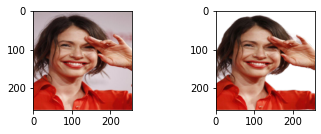

In [52]:
i1 = torchvision.transforms.ToPILImage()(f[5])
i2 = torchvision.transforms.ToPILImage()(t[5])
fig = plt.figure()
a1 = fig.add_subplot(221)
a1.imshow(i1)
a2 = fig.add_subplot(222)
a2.imshow(i2)

plt.show()